<a href="https://colab.research.google.com/github/czarolag/Breast-Cancer-Prognosis-Campus-AI-/blob/main/notebook/Breast_Cancer_Prognosis_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## The Dataset

This notebook explores the SEER cancer registry as our dataset which includes clinical features such as age, tumor size, lymph node status, and hormone receptor status.

&nbsp;
## The Task
The objective of the task is to create a classification model that will predict whether a patient will survive or die. To complete this task, multiple classification models will be implemented that will be trained on the data. This model will be trained to have an an acceptable accuracy rate to predict the label depending on features extracted from the data.

---

In [ ]:
# @title ## Getting our necessary imports (run this cell first)
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')

## Downloading our Dataset

### SEER Dataset


The dataset used in our analysis comes from the Surveillance, Epidemiology, and End Results (SEER) Program, a source of cancer statistics in the United States. SEER collects and publishes cancer incidence and survival data, which researchers can access through the SEER*Stat Software. More on this [here.](https://seer.cancer.gov/statistics/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# read data
df = pd.read_csv('/content/drive/MyDrive/CSC495/seer_dataset_04.csv')

# Potentially leaking so dropped
df = df.drop(columns=['Patient ID'])

Mounted at /content/drive


In [ ]:
df.head()

,Age,Marital Status,Race,Sex,SEQ_NO,Laterality,Histologic,Behavior,Grade,DX_CONF,...,AYA,Estrogen Receptor,Progesterone Receptor,HER2,Breast Subtype,Mets,Regional Nodes Examined,Regional Nodes Positive,Survival Months,Status
0,54,Married (including common law),White,Female,One primary only,Right - origin of primary,8522,8522/3: Infiltrating duct and lobular carcinoma,Moderately differentiated; Grade II,Positive histology,...,9.6.1 Breast - infiltrating duct,Positive,Positive,Negative,HR+/HER2-,False,7,1,84.0,Alive
1,44,Divorced,White,Female,3rd of 3 or more primaries,Right - origin of primary,8010,"8010/3: Carcinoma, NOS",NaN,Positive histology,...,9.6.10 Breast - other,Borderline/Unknown,Borderline/Unknown,Borderline/Unknown,NaN,False,99,99,28.0,Dead
2,82,Widowed,White,Female,2nd of 2 or more primaries,Right - origin of primary,8500,"8500/3: Infiltrating duct carcinoma, NOS",Moderately differentiated; Grade II,Positive histology,...,9.6.1 Breast - infiltrating duct,Positive,Positive,Negative,HR+/HER2-,False,0,98,123.0,Alive
3,56,Married (including common law),White,Female,2nd of 2 or more primaries,Right - origin of primary,8500,"8500/3: Infiltrating duct carcinoma, NOS",Moderately differentiated; Grade II,Positive histology,...,9.6.1 Breast - infiltrating duct,Positive,Positive,Negative,HR+/HER2-,False,1,0,105.0,Alive
4,85,Widowed,Black,Female,2nd of 2 or more primaries,Left - origin of primary,8010,"8010/3: Carcinoma, NOS",NaN,Direct visualization without microscopic confi...,...,9.6.10 Breast - other,Borderline/Unknown,Borderline/Unknown,Borderline/Unknown,NaN,NaN,0,98,10.0,Dead


---

# Preprocessing

Currently, the dataset contains the **features** or the **'x'** values which will be used to train our dataset. It also contains the **labels** or the **'y'** values which are the values that state whether the patient is alive or dead. We will need to preprocess this data to reduce complications when training a model.

In [ ]:
# Categorical Columns: String-like features
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Numerical Columns: Numerical Data
num_cols = df.select_dtypes(include=['number']).columns.tolist()
plot_df = df[num_cols + ['Status']].copy() # hold original values to plot

print("Categorical Features", len(cat_cols))
print("Numerical Features", len(num_cols))

print("Categorical:", cat_cols)
print("Numeric", num_cols)

Categorical Features 22
Numerical Features 6
Categorical: ['Marital Status', 'Race', 'Sex', 'SEQ_NO', 'Laterality', 'Behavior', 'Grade', 'DX_CONF', 'NO_SURG', 'Radiation', 'ICCC', 'ICCCX', 'HIST_GROUP', 'Stage', 'FIRST_MAL', 'AYA', 'Estrogen Receptor', 'Progesterone Receptor', 'HER2', 'Breast Subtype', 'Mets', 'Status']
Numeric ['Age', 'Histologic', 'Tumor Size', 'Regional Nodes Examined', 'Regional Nodes Positive', 'Survival Months']


In [ ]:
# Generate small chart to show unique values
cat_summary = pd.DataFrame({
    'Column': cat_cols,
    'Num Unique': [df[col].nunique(dropna=True) for col in cat_cols]
})

# Generate small chart to show min/max of each feature
num_summary = pd.DataFrame({
    'Column': num_cols,
    'Min': [df[col].min() for col in num_cols],
    'Max': [df[col].max() for col in num_cols],
})

In [ ]:
print(cat_summary)

                   Column  Num Unique
0          Marital Status           6
1                    Race           3
2                     Sex           2
3                  SEQ_NO          14
4              Laterality           5
5                Behavior         156
6                   Grade           4
7                 DX_CONF           8
8                 NO_SURG           7
9               Radiation           8
10                   ICCC          17
11                  ICCCX          28
12             HIST_GROUP          36
13                  Stage           5
14              FIRST_MAL           2
15                    AYA          44
16      Estrogen Receptor           3
17  Progesterone Receptor           3
18                   HER2           3
19         Breast Subtype           4
20                   Mets           2
21                 Status           2


In [ ]:
print(num_summary)

                    Column     Min     Max
0                      Age     2.0    90.0
1               Histologic  8000.0  9930.0
2               Tumor Size     0.0   185.0
3  Regional Nodes Examined     0.0    99.0
4  Regional Nodes Positive     0.0    99.0
5          Survival Months     0.0   155.0


---

### Checking for Null values

We will check for null values in our data. If there are large amounts of missing data, we will drop the column. If missing values are minimal, we can remove those rows as it will not impact the models performance greatly.

In [ ]:
print(df.isnull().sum())

Age                            0
Marital Status                 0
Race                           0
Sex                            0
SEQ_NO                         0
Laterality                     0
Histologic                     0
Behavior                       0
Grade                      40745
DX_CONF                     2521
NO_SURG                     2305
Radiation                      0
ICCC                           0
ICCCX                          2
HIST_GROUP                     0
Stage                      18114
Tumor Size                 23266
FIRST_MAL                      0
AYA                            0
Estrogen Receptor           1996
Progesterone Receptor       1996
HER2                        1996
Breast Subtype             31921
Mets                        7747
Regional Nodes Examined        0
Regional Nodes Positive        0
Survival Months             1563
Status                         0
dtype: int64


As seen from the chart, the columns with missing data are minimal. Instead of removing these columns, we will remove rows where they show up.

In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())

# check how many rows (of data) we still have
print(df.shape[0])

Age                        0
Marital Status             0
Race                       0
Sex                        0
SEQ_NO                     0
Laterality                 0
Histologic                 0
Behavior                   0
Grade                      0
DX_CONF                    0
NO_SURG                    0
Radiation                  0
ICCC                       0
ICCCX                      0
HIST_GROUP                 0
Stage                      0
Tumor Size                 0
FIRST_MAL                  0
AYA                        0
Estrogen Receptor          0
Progesterone Receptor      0
HER2                       0
Breast Subtype             0
Mets                       0
Regional Nodes Examined    0
Regional Nodes Positive    0
Survival Months            0
Status                     0
dtype: int64
324757


---

# Label Encoding and Normalization

We will apply a label encoding to our categorical columns to to convert categorical data (Strings) into a format that machine learning models can understand. This usually means assigning a unique value a number, for example $\{S_0: 0, S_1: 1,...S_n: n\}$

Additionally, we will normalize our numerical columns to keep it more uniform. To do this, a StandardScaler function will be applied to the data.

$$
x' = \frac{x - \mu}{\sigma}
$$

$x$ - original feature value

$\mu$ - mean value of the feature

$\sigma$ - standard deviation of the feature

$x'$ - standardized (scaled) value


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
  df[col] = le.fit_transform(df[col])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# keep original survival months for regression model
surv_months = df['Survival Months'].copy()

for col in num_cols:
  # ensure values are between 0 and 1
  df[col] = scaler.fit_transform(df[[col]])

In [ ]:
df.head()

,Age,Marital Status,Race,Sex,SEQ_NO,Laterality,Histologic,Behavior,Grade,DX_CONF,...,AYA,Estrogen Receptor,Progesterone Receptor,HER2,Breast Subtype,Mets,Regional Nodes Examined,Regional Nodes Positive,Survival Months,Status
0,-0.455565,1,2,0,10,4,0.487901,65,0,2,...,1,2,2,0,1,0,-0.013968,-0.340410,-0.259865,0
2,1.772910,5,2,0,3,4,0.042640,53,0,2,...,1,2,2,0,1,0,-0.479223,2.928484,0.846596,0
3,-0.296388,1,2,0,3,4,0.042640,53,0,2,...,1,2,2,0,1,0,-0.412758,-0.374110,0.335922,0
5,0.897438,1,2,0,3,4,0.042640,53,0,2,...,1,2,1,0,1,0,-0.213363,-0.374110,0.477775,0
7,0.101554,1,2,0,4,4,0.042640,53,1,2,...,1,1,2,0,1,0,-0.479223,2.928484,-0.657056,0


In [ ]:
import pandas as pd

def preview_df_columns_with_dots(df, n_rows=5, n_start_cols=3, n_end_cols=2):
    # Get the first few and last few columns
    start_cols = df.columns[:n_start_cols].tolist()
    end_cols = df.columns[-n_end_cols:].tolist()

    # Subset the DataFrame
    preview = df[start_cols + end_cols].head(n_rows).copy()

    # Insert '...' as a column in between
    preview.insert(n_start_cols, '...', '...')

    return preview

# Example usage
preview_df_columns_with_dots(df)

,Age,Marital Status,Race,...,Survival Months,Status
0,-0.455565,1,2,...,-0.259865,0
2,1.772910,5,2,...,0.846596,0
3,-0.296388,1,2,...,0.335922,0
5,0.897438,1,2,...,0.477775,0
7,0.101554,1,2,...,-0.657056,0


---

# Dataset Split

Before training a model, we must split our downsampled dataset into a 80/20 split. 80% of the data will be used to train the model, while the other 20% will be kept away for testing on unseen data. This will allow us to see how the model performs on new data not seen before. In our case, this is done early on...


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.20, random_state=42)

print('The size of training data is: {} \nThe size of testing data is: {}'.format(len(train_data), len(test_data)))

# ensure shapes of our features and labels x: 11 columns, y: 1 label which is status
print(train_data.shape)
print(test_data.shape)

The size of training data is: 259805 
The size of testing data is: 64952
(259805, 28)
(64952, 28)


---

# Data Visualization

Data visualization is the process of turning data into visuals like graphs, charts, and maps. The purpose is to help understand patterns, trends, and relationships in data more easily. Instead of reading a big table of numbers, a graph can quickly show what is going on and possible correlations.

## Survival Status Distributions (Visualized)

In [ ]:
#Check the distribution of Status to determine Dead vs Alive Victims
def plot_piechart(df, angle=90):
  # get percentages
  status_percent = df["Status"].value_counts(normalize=True) * 100

  # plot percentages
  plt.figure(figsize=(6,6))
  plt.pie(status_percent, labels=["Alive", "Dead"], autopct="%1.1f%%", startangle=angle, colors=["thistle", "moccasin"])
  plt.title('Distribution of Survival Status (Dead vs Alive)')
  plt.axis('equal')
  plt.show()

In [ ]:
#Count Plot of Survival Status
def plot_boxplot_survival(df):
  plt.figure(figsize=(6, 6))
  sns.countplot(x='Status', data=df, hue='Status', palette='pastel', legend=False)
  plt.title('Survival Status Distribution', fontsize=16)
  plt.xlabel('Survival Status', fontsize=14)
  plt.ylabel('Count', fontsize=14)
  plt.show()

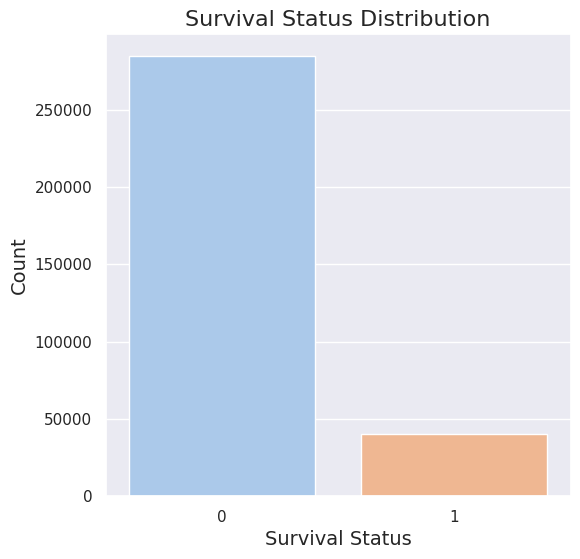

In [ ]:
plot_boxplot_survival(df)

Use Case: To visualize the number of patients who survived (Alive) vs. those who did not (Dead).

Why It Helps: It helps you understand the class distribution of the target variable (Status).

---

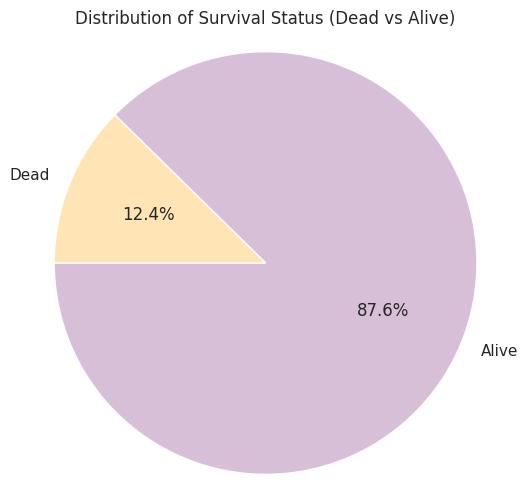

In [ ]:
plot_piechart(train_data, angle=180)

As seen from the pie chart, our data distribution is highly unbalanced. The minority class being **Dead** classifications, the majority class being **Alive** classifications. To fix the issue of **underfitting** and **overfitting** we will apply SMOTE or **Synthetic Minority Oversampling Technique**. Learn more [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

---

### Numerical Features vs. Status

In [ ]:
#Boxplots for numerical features (e.g., Age, Tumor Size, etc.) by Survival Status
def plot_boxplot(df):
  plt.figure(figsize=(12, 8))

  features = [
      ('Age', 'Age vs Survival Status'),
      ('Tumor Size', 'Tumor Size vs Survival Status'),
      ('Regional Nodes Examined', 'Regional Nodes Examined vs Survival Status'),
      ('Regional Nodes Positive', 'Regional Nodes Positive vs Survival Status')
  ]

  for i, (feature, title) in enumerate(features, 1):
      plt.subplot(2, 2, i)
      sns.boxplot(x='Status', y=feature, data=df)
      plt.title(title)

  plt.tight_layout()
  plt.show()

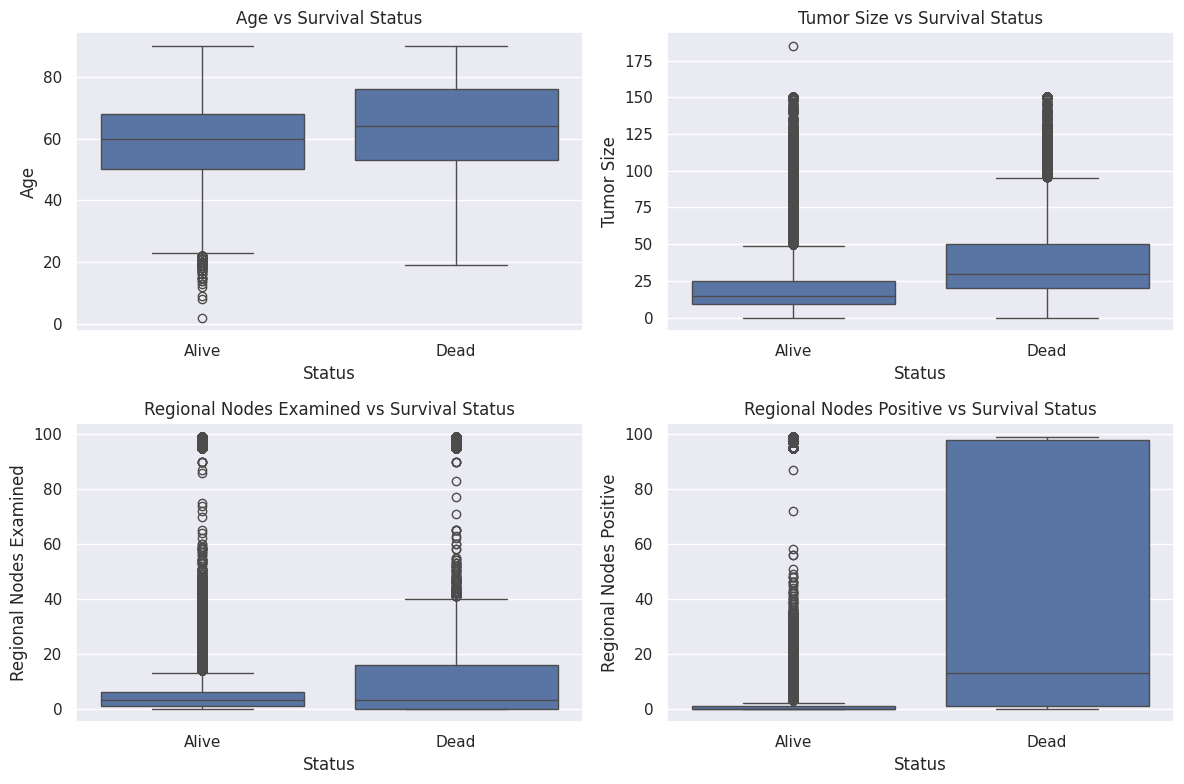

In [ ]:
plot_boxplot(plot_df)

---

# Feature Selection

The data has gone through the preprocessing step. The next step is to select which features to use from the data set. This process reduces feature space while improving the model's performance by reducing computational power.

In [ ]:
'''
plots the correlation heatmap for given dataframe
'''
def plot_correlation(df):
  plt.figure(figsize=(18, 8))
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.25)
  plt.title("Correlation Heatmap")
  plt.show()

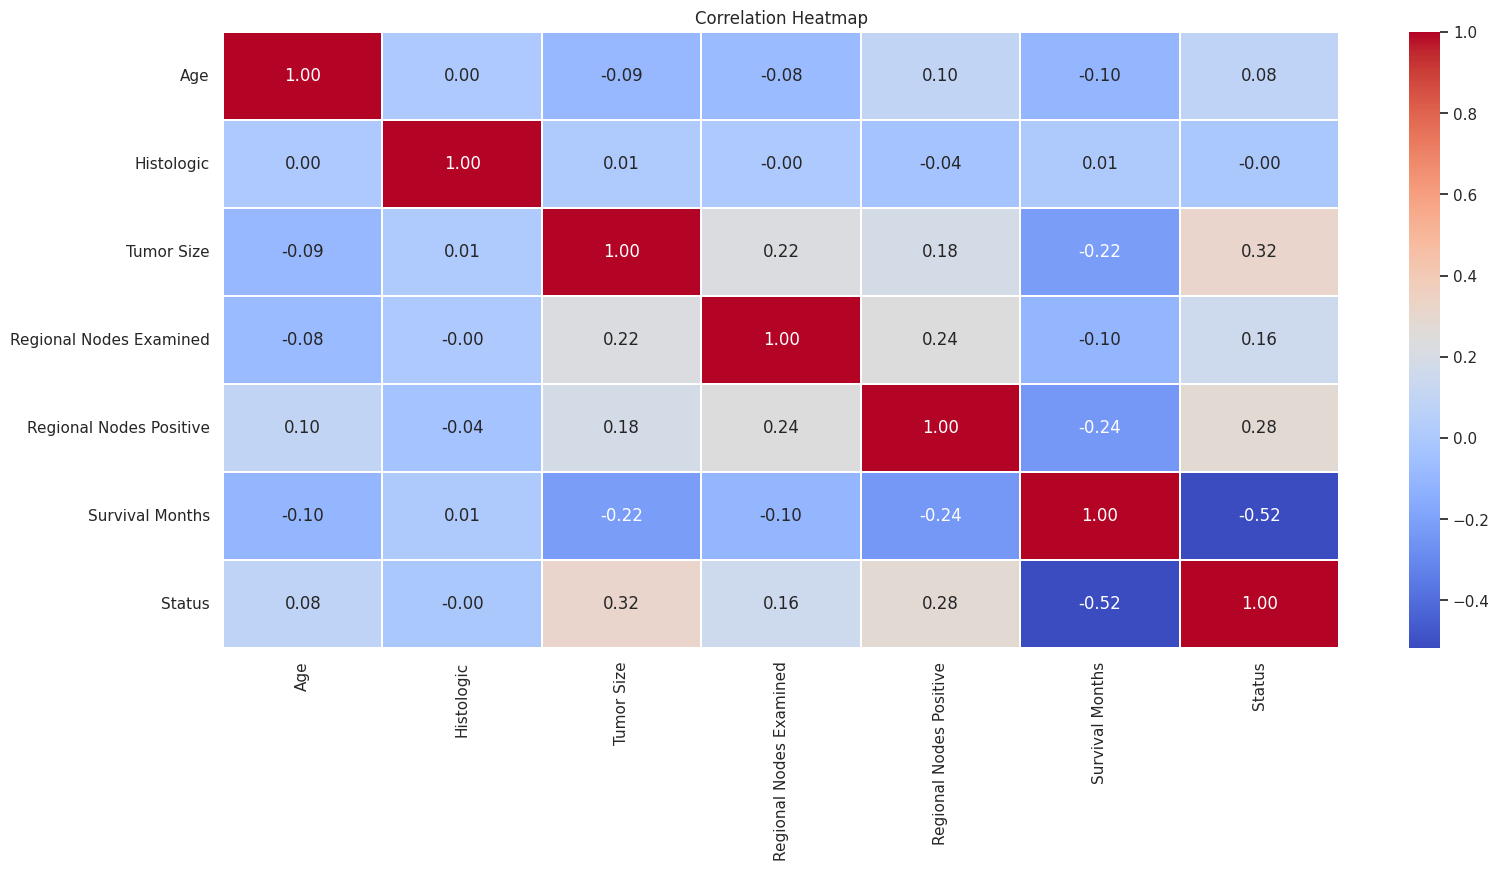

In [ ]:
plot_correlation(df[num_cols + ['Status']])

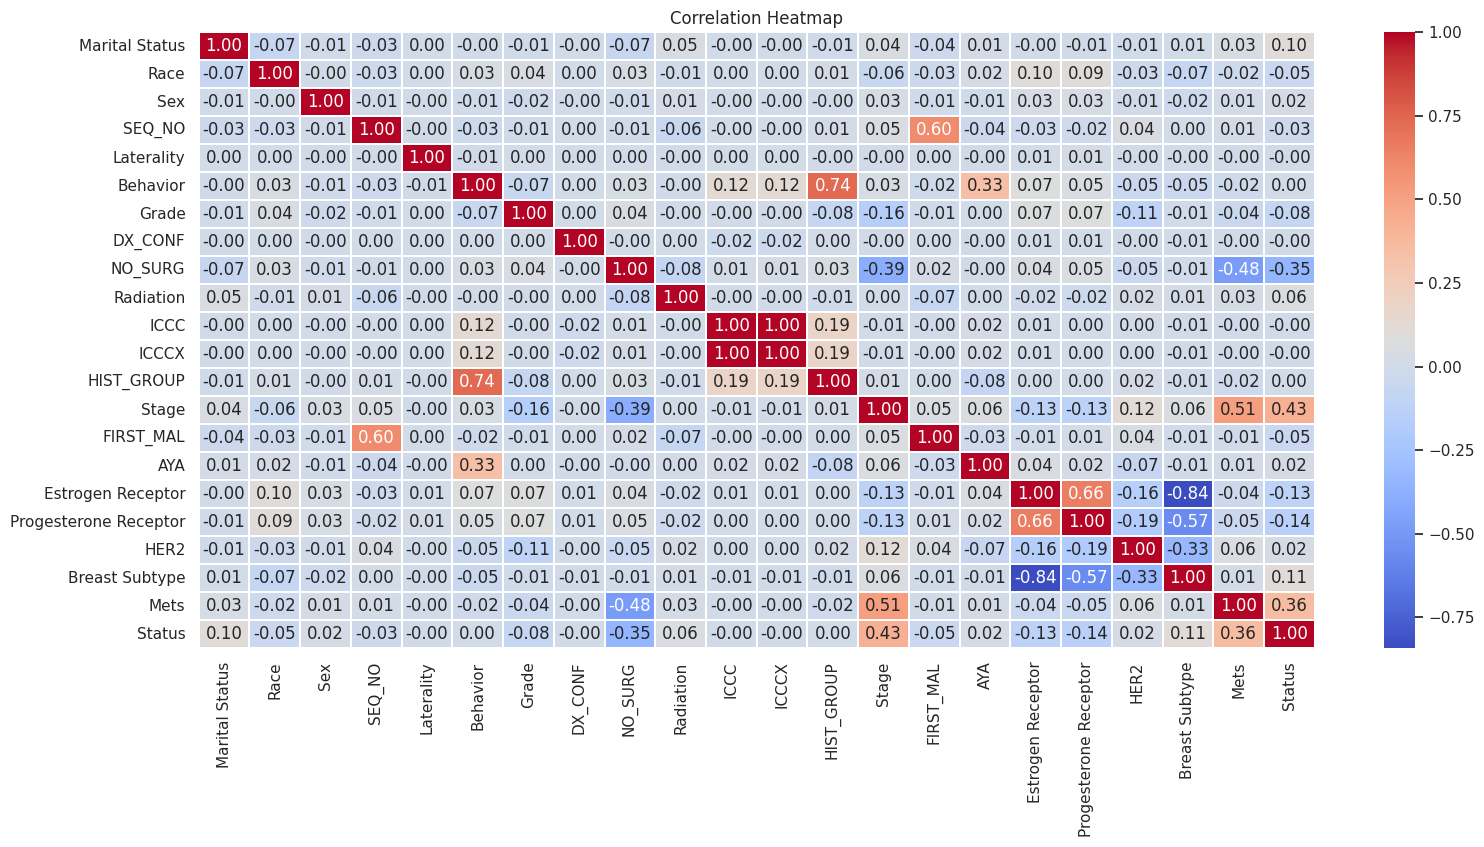

In [ ]:
plot_correlation(df[cat_cols])

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

vif_X = add_constant(df.drop(columns=["Status"]))

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = vif_X.columns
vif_data["VIF"] = [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]
print(vif_data)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                    feature          VIF
0                     const  8742.645222
1                       Age     1.167373
2            Marital Status     1.074983
3                      Race     1.030889
4                       Sex     1.005479
5                    SEQ_NO     1.572476
6                Laterality     1.000227
7                Histologic    24.994492
8                  Behavior     5.342208
9                     Grade     1.049898
10                  DX_CONF     1.000781
11                  NO_SURG     1.787620
12                Radiation     1.022723
13                     ICCC          inf
14                    ICCCX          inf
15               HIST_GROUP    17.370154
16                    Stage     2.642607
17               Tumor Size     1.919995
18                FIRST_MAL     1.598231
19                      AYA     1.559960
20        Estrogen Receptor    13.898450
21    Progesterone Receptor     1.960682
22                     HER2     4.971150
23           Bre

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importance(df):
  # feature variables such as Age, Race, ...
  x_features = df.drop(columns=["Status"])

  # Status ["Alive", "Dead"]
  y_labels = df["Status"]


  # train a model to estimate the importance of each variable
  # n_estimators (number of decision trees in the forest)
  # random_state (integer for same randomness results)
  importance_model = RandomForestClassifier(n_estimators=100, random_state=42)
  importance_model.fit(x_features, y_labels)


  # plot model findings
  feature_importance = pd.Series(importance_model.feature_importances_, index=x_features.columns).sort_values(ascending=False)

  plt.figure(figsize=(10,5))
  sns.barplot(x=feature_importance, y=feature_importance.index)

  plt.xlabel("Feature Score")
  plt.ylabel("Features")
  plt.title("Feature Importance")
  plt.show()

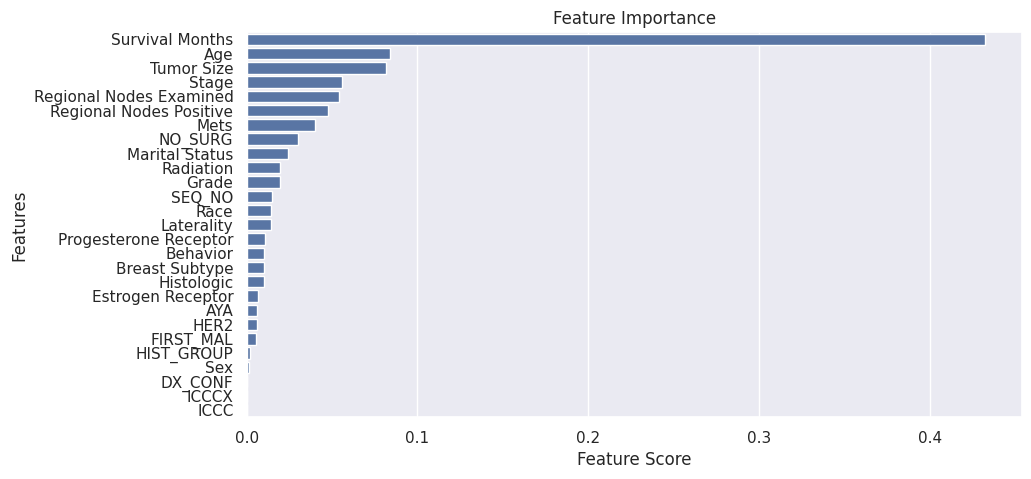

In [ ]:
plot_feature_importance(df)

---

### Removing Low Scoring Features



In [ ]:
# remove low scoring features and highly correlated variables

# high correlations: {ICCCX: ICCC} {HIST_GROUP: Histologic} {Breast Subtype: Estrogen}
# Low Performance: DX_CONF, Sex, Patient ID
feature_removal = ['ICCCX', 'DX_CONF', "Sex", "HIST_GROUP", "Breast Subtype", "ICCC"]
train_data = train_data.drop(columns=feature_removal)
test_data = test_data.drop(columns=feature_removal)

In [ ]:
x_train, y_train = train_data.drop(columns=["Status"]), train_data["Status"]
x_test, y_test = test_data.drop(columns=["Status"]), test_data["Status"]


print('The size of training data is: {} \nThe size of testing data is: {}'.format(len(train_data), len(test_data)))

# ensure shapes of our training/testing samples
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

The size of training data is: 259805 
The size of testing data is: 64952
(259805, 21) (259805,)
(64952, 21) (64952,)


---

# Training a Model

In [ ]:
# @title #### Evaluation Metrics for models (run this cell)

# src: nyandwi
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve

def model_accuracy(input_data, model, labels, NN=False):
    """
    Take the input data, model and labels and return accuracy
    """

    if NN:
        preds = (model.predict(input_data) > 0.5).astype("int32")
    else:
      preds = model.predict(input_data)
    acc = accuracy_score(labels, preds)
    return acc



def model_conf_matrix(input_data, model, labels, class_names=["Alive", "Dead"], NN=False):
    """
    Take the input data, model and labels and return confusion matrix
    """

    if NN:
        preds = (model.predict(input_data) > 0.5).astype("int32")
    else:
      preds = model.predict(input_data)

    cm = confusion_matrix(labels,preds)

    # modified
    # plot confusion matrix in a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names)
    plt.show()



def model_class_report(input_data, model, labels, NN=False):
    """
    Take the input data, model and labels and return confusion matrix
    """

    if NN:
        preds = (model.predict(input_data) > 0.5).astype("int32")
    else:
      preds = model.predict(input_data)

    report = classification_report(labels, preds)
    report = print(report)
    return report



def model_pr_auc(input_data, model, labels, NN=False):
    """
    Compute and display Precision-Recall AUC and curve
    """

    if NN:
        # Use probabilities
        probs = model.predict(input_data).ravel()
    else:
        try:
            probs = model.predict_proba(input_data)[:, 1]
        except AttributeError:
            probs = model.decision_function(input_data)
            probs = (probs - probs.min()) / (probs.max() - probs.min())  # scale to [0, 1]

    pr_auc = average_precision_score(labels, probs)
    precision, recall, _ = precision_recall_curve(labels, probs)

    # Plot the curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"PR AUC Score: {pr_auc:.4f}")
    return pr_auc

---

## Approach 1: RandomForestClassifier

source: [nyandwi](https://colab.research.google.com/github/nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/6_decision_trees_for_classification.ipynb)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with 200 trees
tree_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# fit our training data to the model
tree_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

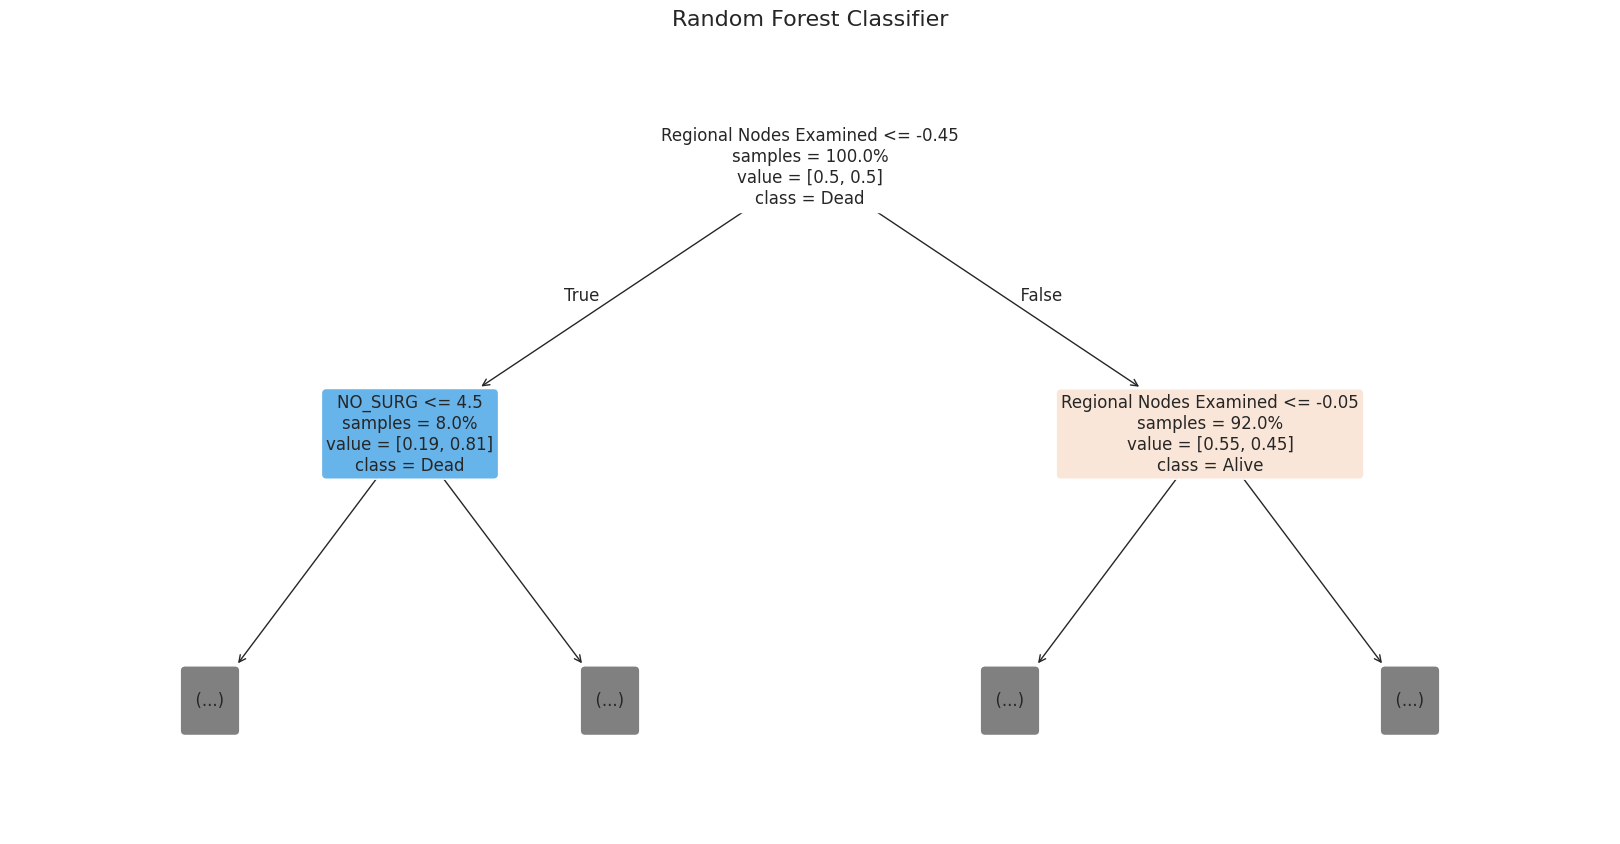

In [ ]:
from sklearn.tree import plot_tree

# visualize the first tree in the forest
first_tree = tree_model.estimators_[0]

plt.figure(figsize=(20, 10))

# Plot the tree with a max depth of 1
plot_tree(
    first_tree,
    filled=True,
    feature_names=x_train.columns,
    class_names=["Alive", "Dead"],
    max_depth=1,
    fontsize=12,
    impurity=False,
    proportion=True,
    rounded=True,
    precision=2,
    label='all'
)

plt.title(f"Random Forest Classifier", fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()

### Evaluating the Model (RSC)

In [ ]:
print("Model Accuracy: ", model_accuracy(x_test, tree_model, y_test))

Model Accuracy:  0.9470532085232172


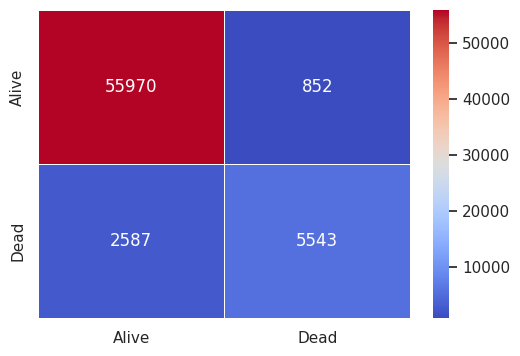

In [ ]:
model_conf_matrix(x_test, tree_model, y_test)

In [ ]:
model_class_report(x_test, tree_model, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     56822
           1       0.87      0.68      0.76      8130

    accuracy                           0.95     64952
   macro avg       0.91      0.83      0.87     64952
weighted avg       0.94      0.95      0.94     64952



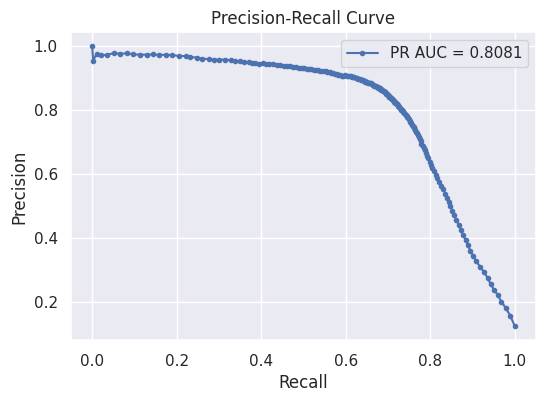

PR AUC Score: 0.8081


np.float64(0.8080544406154709)

In [ ]:
model_pr_auc(x_test, tree_model, y_test)

---

## Approach 2: Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import random

# Set random seeds for consistency
random.seed(42)
tf.random.set_seed(42)

# Define Neural Network Model
NN_model = tf.keras.models.Sequential([
    # input layer
    tf.keras.layers.Input(shape=(x_train.shape[1],)),

    # hidden layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),


    # output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 5
batch_size = 128

# Compile the model
NN_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = NN_model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
)

Epoch 1/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9054 - loss: 0.2744 - val_accuracy: 0.9338 - val_loss: 0.1916
Epoch 2/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9368 - loss: 0.1918 - val_accuracy: 0.9429 - val_loss: 0.1779
Epoch 3/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9406 - loss: 0.1838 - val_accuracy: 0.9442 - val_loss: 0.1739
Epoch 4/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9416 - loss: 0.1813 - val_accuracy: 0.9446 - val_loss: 0.1719
Epoch 5/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9414 - loss: 0.1803 - val_accuracy: 0.9441 - val_loss: 0.1723


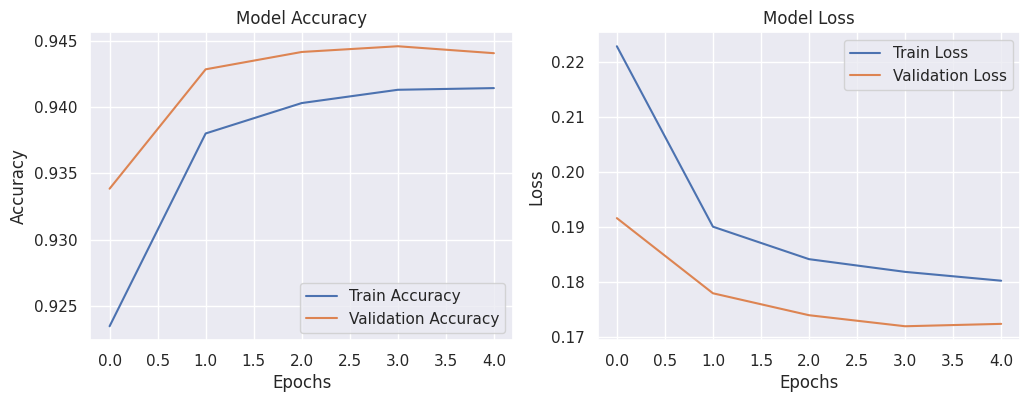

In [ ]:
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

### Evaluating the Model (Neural Network)

In [ ]:
print("Model Accuracy: ", model_accuracy(x_test, NN_model, y_test, NN=True))

2030/2030 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Model Accuracy:  0.9440663874861436


2030/2030 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


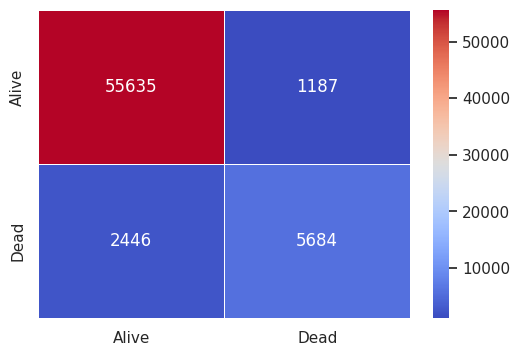

In [ ]:
model_conf_matrix(x_test, NN_model, y_test, NN=True)

In [ ]:
model_class_report(x_test, NN_model, y_test, NN=True)

2030/2030 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     56822
           1       0.83      0.70      0.76      8130

    accuracy                           0.94     64952
   macro avg       0.89      0.84      0.86     64952
weighted avg       0.94      0.94      0.94     64952



2030/2030 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


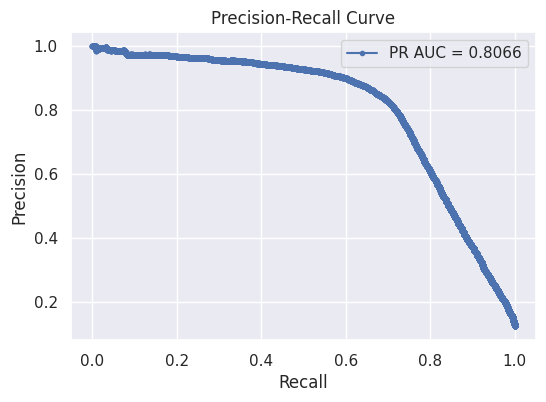

PR AUC Score: 0.8066


np.float64(0.8065995774310306)

In [ ]:
model_pr_auc(x_test, NN_model, y_test, NN=True)

---

## Approach 3: XGBoost (eXtreme Gradient Boosting)

In [ ]:
from xgboost import XGBClassifier

# define the model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

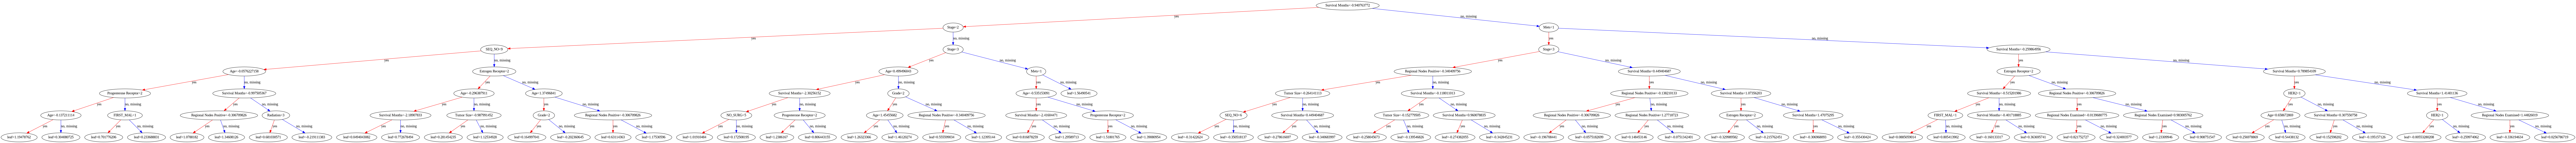

In [ ]:
from xgboost import to_graphviz
from IPython.display import display, Image


dot = to_graphviz(xgb_model, num_trees=0)
dot.render("/content/xgb_tree", format='png')

# Show the PDF
display(Image("/content/xgb_tree.png"))

### Evaluating the Model (XGBoost)

In [ ]:
print("Model Accuracy: ", model_accuracy(x_test, xgb_model, y_test))

Model Accuracy:  0.9475304840497598


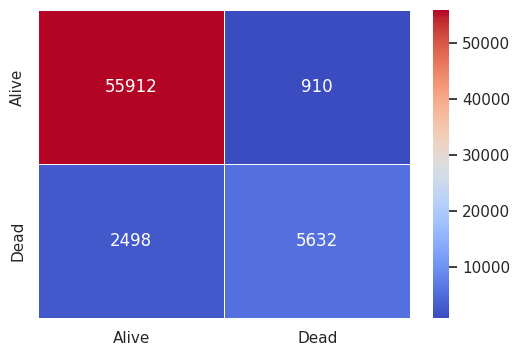

In [ ]:
model_conf_matrix(x_test, xgb_model, y_test)

In [ ]:
model_class_report(x_test, xgb_model, y_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     56822
           1       0.86      0.69      0.77      8130

    accuracy                           0.95     64952
   macro avg       0.91      0.84      0.87     64952
weighted avg       0.95      0.95      0.95     64952



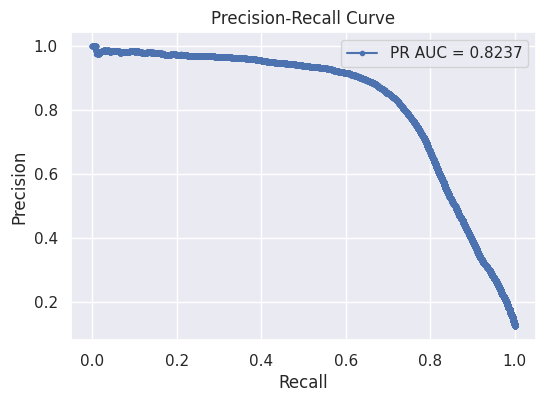

PR AUC Score: 0.8237


np.float64(0.8236733494898972)

In [ ]:
model_pr_auc(x_test, xgb_model, y_test)

---

# Survival Analysis Models


# XGBoost-Cox Proportional Hazard Model

In [ ]:
!pip install -q scikit-survival lifelines

import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.9 MB/s eta 0:00:00


In [ ]:
# get df and input non-normalized survival months
df_regr = df.copy()
df_regr["Survival Months"] = surv_months

# Remove months that go beyond 10 years
# df_regr = df_regr[df_regr["Survival Months"] <= 120].copy()


df_regr['event'] = df_regr['Status'] == 1

df_regr.head()

,Age,Marital Status,Race,Sex,SEQ_NO,Laterality,Histologic,Behavior,Grade,DX_CONF,...,Estrogen Receptor,Progesterone Receptor,HER2,Breast Subtype,Mets,Regional Nodes Examined,Regional Nodes Positive,Survival Months,Status,event
0,-0.455565,1,2,0,10,4,0.487901,65,0,2,...,2,2,0,1,0,-0.013968,-0.340410,84.0,0,False
2,1.772910,5,2,0,3,4,0.042640,53,0,2,...,2,2,0,1,0,-0.479223,2.928484,123.0,0,False
3,-0.296388,1,2,0,3,4,0.042640,53,0,2,...,2,2,0,1,0,-0.412758,-0.374110,105.0,0,False
5,0.897438,1,2,0,3,4,0.042640,53,0,2,...,2,1,0,1,0,-0.213363,-0.374110,110.0,0,False
7,0.101554,1,2,0,4,4,0.042640,53,1,2,...,1,2,0,1,0,-0.479223,2.928484,70.0,0,False


In [ ]:
X_xgb = df_regr.drop(columns=["Status", "Survival Months", "event"])

# Structure the array
y_xgb = np.array(
    [(bool(e), t) for e, t in zip(df_regr['event'], df_regr['Survival Months'])],
    dtype=[('event', 'bool'), ('time', 'float')]
)

In [ ]:
from sklearn.model_selection import train_test_split

# 80/20 split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=df_regr['event']
)


# validation split
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(
    X_train1, y_train1, test_size=0.2, random_state=42
)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train1, label=y_train1["time"])
dtest = xgb.DMatrix(X_test1)
dvalid = xgb.DMatrix(X_valid1, label=y_valid1["time"])


params = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "learning_rate": 0.01,
    "tree_method": "hist",
    "subsample": 0.8,
    "colsample_bynode": 0.8,
    "gamma": 1,
    "reg_alpha": 1,
    "reg_lambda": 5,
    "max_depth": 4,
    "verbosity": 2
}

In [ ]:
# Training the model
cox_ph_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    early_stopping_rounds=50,
    evals = [(dtrain, "train"), (dvalid, "valid")],
)

### Evaluate the XGBoost - Cox Proportional Hazard Mod:el

In [ ]:
# calculate risk scores on test data
risk_scores_xgb = cox_ph_model.predict(xgb.DMatrix(X_test1))

In [ ]:
risk_quantiles = np.quantile(risk_scores_xgb, [1/3, 2/3])

def assign_risk_group(score):
    if score <= risk_quantiles[0]:
        return "Low"
    elif score <= risk_quantiles[1]:
        return "Medium"
    else:
        return "High"

risk_groups = pd.Series(risk_scores_xgb).apply(assign_risk_group)

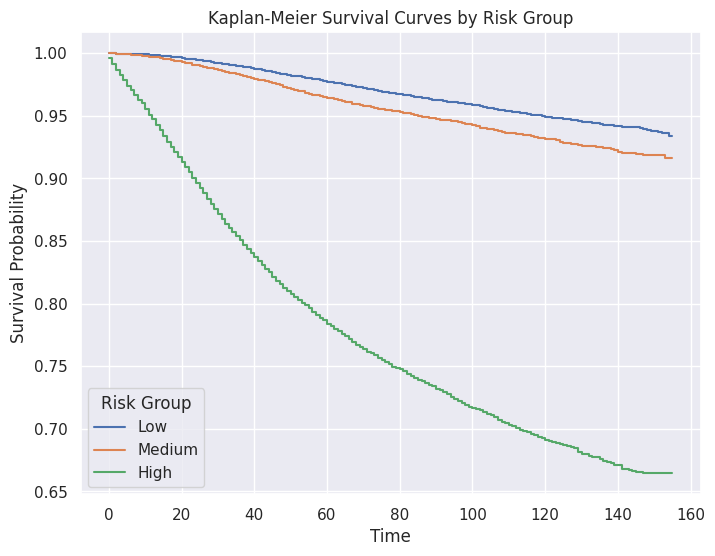

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for group in ["Low", "Medium", "High"]:
    mask = risk_groups == group
    kmf.fit(durations=y_test1["time"][mask],
            event_observed=y_test1["event"][mask],
            label=group)
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by Risk Group")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend(title="Risk Group")
plt.show()


In [ ]:
from sksurv.metrics import concordance_index_censored

c_index = concordance_index_censored(y_test1["event"], y_test1["time"], risk_scores_xgb)
print(f"Updated C-index: {c_index[0]:.3f}")

Updated C-index: 0.800


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv

y_train_structured = Surv.from_arrays(y_train1["event"], y_train1["time"])
y_test_structured = Surv.from_arrays(y_test1["event"], y_test1["time"])


times_to_evaluate = np.percentile(y_test1["time"], np.linspace(10, 90, 20))

aucs = []

for t in times_to_evaluate:
    _, auc_t = cumulative_dynamic_auc(
        y_train_structured,
        y_test_structured,
        risk_scores_xgb,
        np.array([t])
    )
    aucs.append(auc_t)

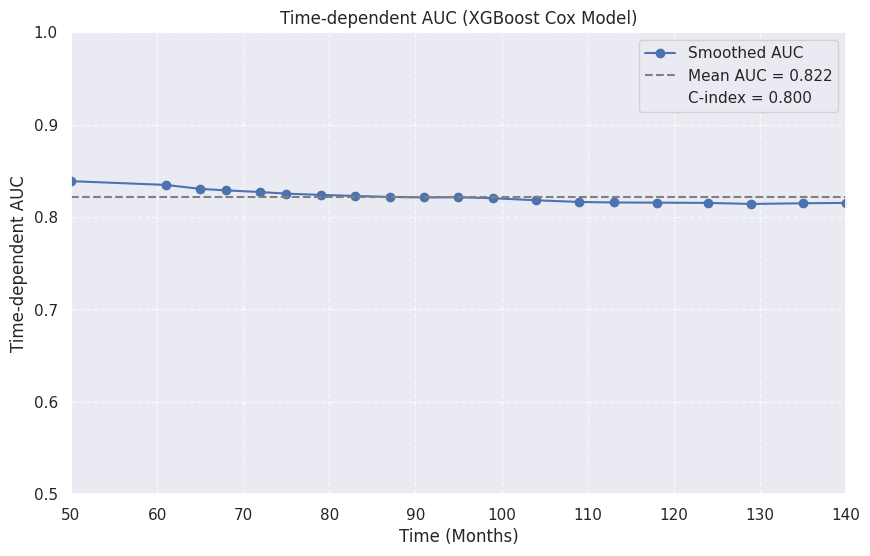

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from matplotlib.lines import Line2D

# Smooth AUC curve
smooth_aucs = uniform_filter1d(aucs, size=3)
integrated_auc = np.mean(aucs)

c_index_text = f"C-index = {c_index[0]:.3f}"
c_index_handle = Line2D([], [], color='none', label=c_index_text)

# Plot
plt.figure(figsize=(10,6))
line1, = plt.plot(times_to_evaluate, smooth_aucs, marker='o', label='Smoothed AUC')
line2 = plt.axhline(y=integrated_auc, color='gray', linestyle='--', label=f"Mean AUC = {integrated_auc:.3f}")

plt.ylim(0.5, 1)
plt.xlim(times_to_evaluate.min(), times_to_evaluate.max())
plt.xlabel("Time (Months)")
plt.ylabel("Time-dependent AUC")
plt.title("Time-dependent AUC (XGBoost Cox Model)")
plt.grid(True, linestyle="--", alpha=0.7)

handles = [line1, line2, c_index_handle]
labels = [h.get_label() for h in handles]
plt.legend(handles, labels)

plt.show()


---